In [1]:
# from google.colab import drive
# drive.mount('/gdrive')

In [2]:
!python3 --version

Python 3.9.16


In [3]:
# !pip3 install -q odc.stac
# !pip3 install -q geopandas
# !pip3 install -q planetary_computer
# !pip3 install -q rioxarray
# !pip3 install -q loguru

In [4]:
# %load_ext lab_black
%load_ext autoreload
%autoreload 2

In [5]:
import cv2
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
import odc.stac
import pandas as pd
from pathlib import Path
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import gc
import os

import multiprocessing
from multiprocessing import Pool

%matplotlib inline

In [6]:
import geopy.distance as distance

# get our bounding box to search latitude and longitude coordinates
def get_bounding_box(latitude, longitude, meter_buffer=50000):
    """
    Given a latitude, longitude, and buffer in meters, returns a bounding
    box around the point with the buffer on the left, right, top, and bottom.

    Returns a list of [minx, miny, maxx, maxy]
    """
    distance_search = distance.distance(meters=meter_buffer)

    # calculate the lat/long bounds based on ground distance
    # bearings are cardinal directions to move (south, west, north, and east)
    min_lat = distance_search.destination((latitude, longitude), bearing=180)[0]
    min_long = distance_search.destination((latitude, longitude), bearing=270)[1]
    max_lat = distance_search.destination((latitude, longitude), bearing=0)[0]
    max_long = distance_search.destination((latitude, longitude), bearing=90)[1]

    return [min_long, min_lat, max_long, max_lat]



In [7]:
DATA_DIR = ''#Path.cwd().parent.resolve() / "data/final/public"
# DATA_DIR = '/gdrive/My Drive/Colab Notebooks/HarmfulAlgalBloomDetection/'#Path.cwd().parent.resolve() / "data/final/public"
# assert DATA_DIR.exists()

In [8]:
metadata = pd.read_csv(DATA_DIR + "metadata.csv")
metadata.head()

,uid,latitude,longitude,date,split
0,aabm,39.080319,-86.430867,2018-05-14,train
1,aabn,36.559700,-121.510000,2016-08-31,test
2,aacd,35.875083,-78.878434,2020-11-19,train
3,aaee,35.487000,-79.062133,2016-08-24,train
4,aaff,38.049471,-99.827001,2019-07-23,train


In [9]:
len(metadata.uid.unique())

23570

In [10]:
len(metadata.loc[:,['latitude','longitude' 	]].drop_duplicates())

12681

In [11]:
duplicated_rows=np.where(metadata.loc[:,['latitude','longitude' 	]].duplicated()==True)[0]
duplicated_rows

array([   79,   106,   107, ..., 23565, 23566, 23569])

In [12]:
metadata.iloc[duplicated_rows[0],:]

uid                acdj
latitude        37.3906
longitude      -120.958
date         2015-04-14
split             train
Name: 79, dtype: object

In [13]:
metadata.loc[metadata['latitude']==metadata.latitude.iloc[duplicated_rows[0]],:].head()

,uid,latitude,longitude,date,split
22,aaqc,37.3906,-120.958,2013-07-09,train
79,acdj,37.3906,-120.958,2015-04-14,train
1701,bxeq,37.3906,-120.958,2019-09-10,train
2302,conk,37.3906,-120.958,2019-12-04,train
2409,crja,37.3906,-120.958,2021-07-13,train


In [14]:
metadata.split.value_counts(dropna=False)

train    17060
test      6510
Name: split, dtype: int64

In [15]:
import geopandas as gpd
from shapely.geometry import Point

# load the default geopandas base map file to plot points on
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

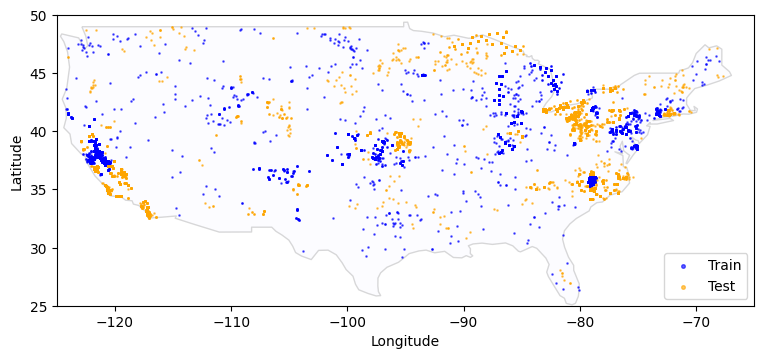

In [16]:
fig, ax = plt.subplots(figsize=(9, 4))

# map the training data
base = world[world.name == "United States of America"].plot(
    edgecolor="gray", color="ghostwhite", figsize=(9, 4), alpha=0.3, ax=ax
)
train_meta = metadata[metadata["split"] == "train"]
geometry = [Point(xy) for xy in zip(train_meta["longitude"], train_meta["latitude"])]
gdf = gpd.GeoDataFrame(train_meta, geometry=geometry)
gdf.plot(ax=base, marker=".", markersize=3, color="blue", label="Train", alpha=0.6)

# map the test data
test_meta = metadata[metadata["split"] == "test"]
geometry = [Point(xy) for xy in zip(test_meta["longitude"], test_meta["latitude"])]
gdf = gpd.GeoDataFrame(test_meta, geometry=geometry)
gdf.plot(ax=base, marker=".", markersize=3, color="orange", label="Test", alpha=0.6)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.xlim([-125, -65])
plt.ylim([25, 50])
plt.legend(loc=4, markerscale=3)
plt.show()

In [17]:
# convert date to pd.datetime
metadata.date = pd.to_datetime(metadata.date)

# what is the date range?
metadata.groupby("split").agg(min_date=("date", min), max_date=("date", max))

,min_date,max_date
split,,
test,2013-01-08,2021-12-29
train,2013-01-04,2021-12-14


In [18]:
# # what years are in the data?
# pd.crosstab(metadata.date.dt.year, metadata.split).plot(kind="bar")
# plt.ylabel("Number of samples")
# plt.xlabel("Year")
# plt.title("Distribution of years in the data")
# plt.show()

In [19]:
# what seasons are the data points from?
metadata["season"] = (
    metadata.date.dt.month.replace([12, 1, 2], "winter")
    .replace([3, 4, 5], "spring")
    .replace([6, 7, 8], "summer")
    .replace([9, 10, 11], "fall")
)
metadata.season.value_counts()

summer    10813
spring     5045
fall       4758
winter     2954
Name: season, dtype: int64

In [20]:
# # where is data from for each season?
# fig, axes = plt.subplots(2, 2, figsize=(10, 5))

# for season, ax in zip(metadata.season.unique(), axes.flatten()):
#     base = world[world.name == "United States of America"].plot(
#         edgecolor="gray", color="ghostwhite", alpha=0.3, ax=ax
#     )

#     sub = metadata[metadata.season == season]
#     geometry = [Point(xy) for xy in zip(sub["longitude"], sub["latitude"])]
#     gdf = gpd.GeoDataFrame(sub, geometry=geometry)
#     gdf.plot(ax=base, marker=".", markersize=2.5)
#     ax.set_xlim([-125, -66])
#     ax.set_ylim([25, 50])
#     ax.set_title(f"{season.capitalize()} data points")
#     ax.axis("off")

In [21]:
train_labels = pd.read_csv(DATA_DIR + "train_labels.csv")
train_labels.head()

,uid,region,severity,density
0,aabm,midwest,1,585.0
1,aacd,south,1,290.0
2,aaee,south,1,1614.0
3,aaff,midwest,3,111825.0
4,aafl,midwest,4,2017313.0


In [22]:
train_labels_and_metadata = train_labels.merge(
    metadata, how="left", left_on="uid", right_on="uid", validate="1:1"
)

Text(0.5, 1.0, 'Train labels severity level counts')

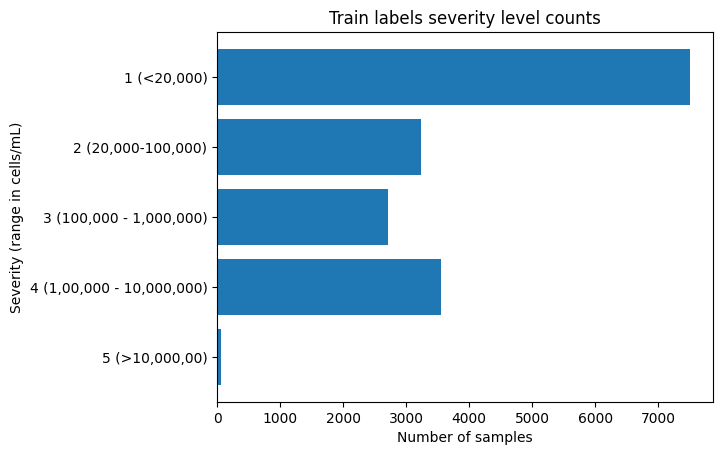

In [23]:
severity_counts = (
    train_labels.replace(
        {
            "severity": {
                1: "1 (<20,000)",
                2: "2 (20,000-100,000)",
                3: "3 (100,000 - 1,000,000)",
                4: "4 (1,00,000 - 10,000,000)",
                5: "5 (>10,000,00)",
            }
        }
    )
    .severity.value_counts()
    .sort_index(ascending=False)
)
plt.barh(severity_counts.index, severity_counts.values)
plt.xlabel("Number of samples")
plt.ylabel("Severity (range in cells/mL)")
plt.title("Train labels severity level counts")

In [24]:
train_labels.density.describe()

count    1.706000e+04
mean     1.074537e+06
std      6.836693e+06
min      0.000000e+00
25%      4.066000e+03
50%      3.270975e+04
75%      4.849192e+05
max      8.046675e+08
Name: density, dtype: float64

In [25]:
(train_labels.density == 0).sum()

91

In [26]:
submission_format = pd.read_csv(DATA_DIR + "submission_format.csv", index_col=0)
submission_format.head()

,region,severity
uid,,
aabn,west,1
aair,west,1
aajw,northeast,1
aalr,midwest,1
aalw,west,1


In [27]:
submission_format.shape

(6510, 2)

In [28]:
# Establish a connection to the STAC API
import planetary_computer as pc
from pystac_client import Client

catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1", modifier=pc.sign_inplace
)

In [29]:
# grand_canyon = [-112.15, 36.05]
# search = catalog.search(
#     collections=["cop-dem-glo-30"],
#     intersects={"type": "Point", "coordinates": grand_canyon},
# )
# items = list(search.get_items())

In [54]:
# import planetary_computer
import rioxarray

# signed_asset = planetary_computer.sign(items[0].assets["data"])
# data = (
#     rioxarray.open_rasterio(signed_asset.href)
#     .squeeze()
#     .drop("band")
#     .coarsen({"y": 1, "x": 1})
# #     .coarsen({"y": 5, "x": 5})
#     .mean()
# )


In [31]:
# plt.imshow(data)
# plt.show()

In [33]:
# bbox = get_bounding_box(36.05, -112.15, meter_buffer=20000)
# bbox

In [34]:
# (minx, miny, maxx, maxy) = bbox
# image = data.rio.clip_box(
#         minx=minx,
#         miny=miny,
#         maxx=maxx,
#         maxy=maxy,
#         crs="EPSG:4326",
#     )
# plt.imshow(image)
# plt.show()
# image.shape,image[int(image.shape[0]/2),int(image.shape[1]/2)]

In [35]:
# imc=image.to_numpy().copy()
# imc=cv2.resize(imc, (int(imc.shape[1]/5),int(imc.shape[0]/5)))
# image.shape,imc.shape

In [36]:
# np.where(data.x==-112.15),np.where(data.y==36.05),data[np.where(data.y==36.05)[0][0],np.where(data.x==-112.15)[0][0]]


In [37]:
metadata['latlong']=metadata['latitude'].round(2).astype(str)+'_'+metadata['longitude'].round(2).astype(str)
unique_points=np.unique(metadata.latlong)
metadata.head()

,uid,latitude,longitude,date,split,season,latlong
0,aabm,39.080319,-86.430867,2018-05-14,train,spring,39.08_-86.43
1,aabn,36.559700,-121.510000,2016-08-31,test,summer,36.56_-121.51
2,aacd,35.875083,-78.878434,2020-11-19,train,fall,35.88_-78.88
3,aaee,35.487000,-79.062133,2016-08-24,train,summer,35.49_-79.06
4,aaff,38.049471,-99.827001,2019-07-23,train,summer,38.05_-99.83


In [38]:
# distance_search = distance.distance(meters=1000)

# # calculate the lat/long bounds based on ground distance
# # bearings are cardinal directions to move (south, west, north, and east)
# distance_search.destination((39.080319,-86.430867), bearing=180)[0]

In [39]:
# len(metadata),len(unique_points)

In [40]:
lat,long=unique_points[0].split('_')
lat=float(lat)
long=float(long)
unique_points[0],lat,long

('26.39_-80.11', 26.39, -80.11)

In [41]:
metadata.head()

,uid,latitude,longitude,date,split,season,latlong
0,aabm,39.080319,-86.430867,2018-05-14,train,spring,39.08_-86.43
1,aabn,36.559700,-121.510000,2016-08-31,test,summer,36.56_-121.51
2,aacd,35.875083,-78.878434,2020-11-19,train,fall,35.88_-78.88
3,aaee,35.487000,-79.062133,2016-08-24,train,summer,35.49_-79.06
4,aaff,38.049471,-99.827001,2019-07-23,train,summer,38.05_-99.83


In [42]:
metadata.loc[metadata.uid=='aabm','longitude'].values[0]

-86.4308666666667

In [43]:

# IMAGE_ARRAY_DIR='benchmark/dem2K/'
# uids_saved=([x.split('_')[0] for x in os.listdir(IMAGE_ARRAY_DIR)])
# len(uids_saved)

In [44]:
# unsaved_uids=pd.DatetimeIndex(metadata.loc[~metadata.uid.isin(uids_saved),'uid'])#.unique())
# unsaved_uids=[x for x in metadata.uid.values if x not in uids_saved]
# len(unsaved_uids)#,len(undates)

In [45]:
metadata=pd.read_csv('metadata.csv')
metadata['date']=pd.to_datetime(metadata['date'])
metadata.head()

,uid,latitude,longitude,date,split
0,aabm,39.080319,-86.430867,2018-05-14,train
1,aabn,36.559700,-121.510000,2016-08-31,test
2,aacd,35.875083,-78.878434,2020-11-19,train
3,aaee,35.487000,-79.062133,2016-08-24,train
4,aaff,38.049471,-99.827001,2019-07-23,train


In [46]:
# undates=metadata['date'].unique()
undates=np.unique(metadata['date'])
undates=pd.DatetimeIndex(undates)
len(undates),undates[0]

(1637, Timestamp('2013-01-04 00:00:00'))

In [47]:
from datetime import date, timedelta

# Constants for creating the full URL
blob_container = "https://noaahrrr.blob.core.windows.net/hrrr"
sector = "conus"
# yesterday = date.today() - timedelta(days=1)
yesterday = undates[0].date()
cycle = 12          # noon
forecast_hour = 1   # offset from cycle time
product = "wrfsfcf" # 2D surface levels

# Put it all together
file_path = f"hrrr.t{cycle:02}z.{product}{forecast_hour:02}.grib2"
url = f"{blob_container}/hrrr.{yesterday:%Y%m%d}/{sector}/{file_path}"

print(url)



https://noaahrrr.blob.core.windows.net/hrrr/hrrr.20130104/conus/hrrr.t12z.wrfsfcf01.grib2


In [57]:
# import s3fs 
# import xarray 

# s3 = s3fs.S3FileSystem(anon=True)
# def lookup(path):
#     return s3fs.S3Map(path, s3=s3)

# path = "hrrrzarr/sfc/20210101/20210101_00z_anl.zarr/surface/TMP" 
# ds = xarray.open_mfdataset([lookup(path), lookup(f"{path}/surface")], 
# #  engine="scipy") 
#  engine="cfgrib") 

# ds.TMP.plot()

In [58]:
# import requests

# sector = "conus"
# cycle = 12  # noon
# forecast_hour = 1  # offset from cycle time
# product = "wrfprsf"  # 3D Pressure Levels
# sample_date = "20190826"  # August 8 2019

# file_path = f"hrrr.t{cycle:02}z.{product}{forecast_hour:02}.grib2"
# url = f"https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr.{sample_date}/{sector}/{file_path}"
# print(f"Full URL: {url}")

# r = requests.get(f"{url}.idx")
# idx = r.text.splitlines()

# # Full URL: https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr.20190826/conus/hrrr.t12z.wrfprsf01.grib2

In [48]:
import tempfile, requests

In [49]:
from tqdm import tqdm
# NUM_DAYS_BEFORE=14
NUM_DAYS_BEFORE=28
METER_BUFFER=50000
METER_BUFFER=5000
# undates


CLIM_ARRAY_DIR='climateR_d'+str(NUM_DAYS_BEFORE)+'_b'+str(METER_BUFFER)+'/'

blob_container = "https://noaa-hrrr-bdp-pds.s3.amazonaws.com"
cycle = 12          # noon
forecast_hour = 1   # offset from cycle time
product = "wrfsfcf" # 2D surface levels

undate = metadata.date[0].date()

In [58]:
undate = metadata.date[2].date()
date = undate -timedelta(0)

# Put it all together
file_path = f"hrrr.t{cycle:02}z.{product}{forecast_hour:02}.grib2"
url = f"{blob_container}/hrrr.{date:%Y%m%d}/{sector}/{file_path}"

#         print(url)

# Fetch the idx file by appending the .idx file extension to our already formatted URL
r = requests.get(f"{url}.idx")
idx = r.text.splitlines()


# Let's grab surface temperature `TMP:surface`.
sfc_temp_idx = [l for l in idx if ":CRAIN:surface" in l][0].split(":")
sfc_temp_idx = [l for l in idx if ":GUST:surface" in l][0].split(":")
sfc_temp_idx = [l for l in idx if ":SNOWC:surface" in l][0].split(":")
sfc_temp_idx = [l for l in idx if ":HGT:surface" in l][0].split(":")
# sfc_temp_idx = [l for l in idx if ":ULWRF:surface" in l][0].split(":")


In [59]:
metadata.date[2].date()

datetime.date(2020, 11, 19)

In [60]:
sfc_temp_idx

['58', '37787274', 'd=2020111912', 'HGT', 'surface', '1 hour fcst', '']

In [61]:
line_num = int(sfc_temp_idx[0])
range_start = sfc_temp_idx[1]

# The line number values are 1-indexed, so we don't need to increment it to get the next list index,
# but check we're not already reading the last line
next_line = idx[line_num].split(':') if line_num < len(idx) else None

# Pluck the start of the next byte offset, or nothing if we were on the last line
range_end = next_line[1] if next_line else None

#         print(f"Byte range: {range_start}-{range_end}")


file = tempfile.NamedTemporaryFile(prefix="tmp_"+str(date)+'_db'+str(0), delete=False)

headers = {"Range": f"bytes={range_start}-{range_end}"}
resp = requests.get(url, headers=headers, stream=True)

with file as f:
    f.write(resp.content)

image = rioxarray.open_rasterio(file.name, engine='cfgrib')#.to_numpy()

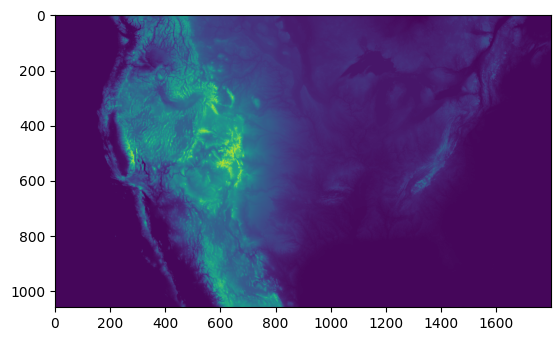

In [62]:
plt.imshow(image.to_numpy()[0])
plt.show()

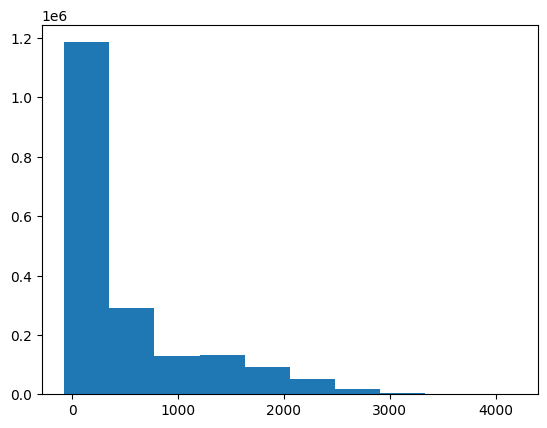

In [63]:
plt.hist(image.to_numpy()[0].flatten())
plt.show()

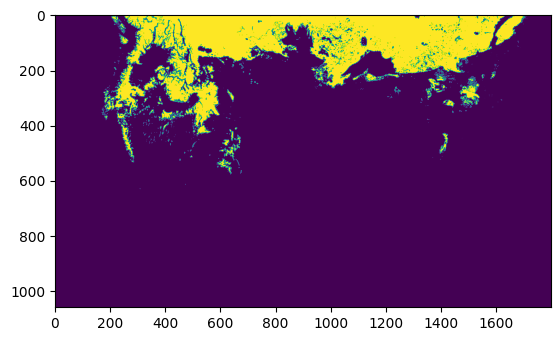

In [64]:
sfc_temp_idx = [l for l in idx if ":CRAIN:surface" in l][0].split(":")
sfc_temp_idx = [l for l in idx if ":GUST:surface" in l][0].split(":")
sfc_temp_idx = [l for l in idx if ":SNOWC:surface" in l][0].split(":")
# sfc_temp_idx = [l for l in idx if ":HGT:surface" in l][0].split(":")

line_num = int(sfc_temp_idx[0])
range_start = sfc_temp_idx[1]

next_line = idx[line_num].split(':') if line_num < len(idx) else None
range_end = next_line[1] if next_line else None

file = tempfile.NamedTemporaryFile(prefix="tmp_"+str(date)+'_db'+str(0), delete=False)

headers = {"Range": f"bytes={range_start}-{range_end}"}
resp = requests.get(url, headers=headers, stream=True)

with file as f:
    f.write(resp.content)

image = rioxarray.open_rasterio(file.name, engine='cfgrib')#.to_numpy()
plt.imshow(image.to_numpy()[0])
plt.show()

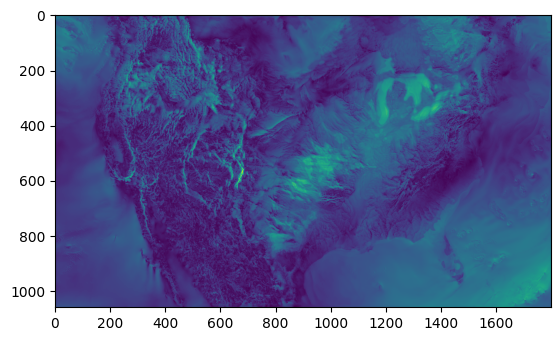

In [65]:
sfc_temp_idx = [l for l in idx if ":CRAIN:surface" in l][0].split(":")
sfc_temp_idx = [l for l in idx if ":GUST:surface" in l][0].split(":")
# sfc_temp_idx = [l for l in idx if ":SNOWC:surface" in l][0].split(":")
# sfc_temp_idx = [l for l in idx if ":HGT:surface" in l][0].split(":")

line_num = int(sfc_temp_idx[0])
range_start = sfc_temp_idx[1]

next_line = idx[line_num].split(':') if line_num < len(idx) else None
range_end = next_line[1] if next_line else None

file = tempfile.NamedTemporaryFile(prefix="tmp_"+str(date)+'_db'+str(0), delete=False)

headers = {"Range": f"bytes={range_start}-{range_end}"}
resp = requests.get(url, headers=headers, stream=True)

with file as f:
    f.write(resp.content)

image = rioxarray.open_rasterio(file.name, engine='cfgrib')#.to_numpy()
plt.imshow(image.to_numpy()[0])
plt.show()

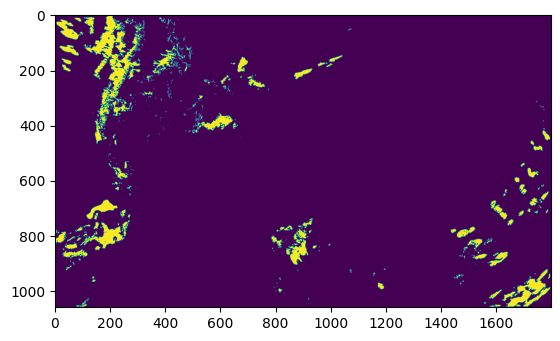

In [66]:
sfc_temp_idx = [l for l in idx if ":CRAIN:surface" in l][0].split(":")
# sfc_temp_idx = [l for l in idx if ":GUST:surface" in l][0].split(":")
# sfc_temp_idx = [l for l in idx if ":SNOWC:surface" in l][0].split(":")
# sfc_temp_idx = [l for l in idx if ":HGT:surface" in l][0].split(":")

line_num = int(sfc_temp_idx[0])
range_start = sfc_temp_idx[1]

next_line = idx[line_num].split(':') if line_num < len(idx) else None
range_end = next_line[1] if next_line else None

file = tempfile.NamedTemporaryFile(prefix="tmp_"+str(date)+'_db'+str(0), delete=False)

headers = {"Range": f"bytes={range_start}-{range_end}"}
resp = requests.get(url, headers=headers, stream=True)

with file as f:
    f.write(resp.content)

image = rioxarray.open_rasterio(file.name, engine='cfgrib')#.to_numpy()
plt.imshow(image.to_numpy()[0])
plt.show()

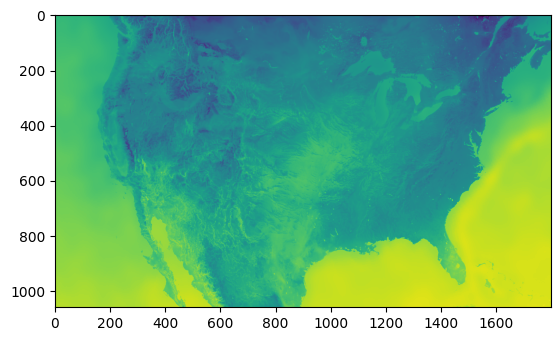

In [69]:
sfc_temp_idx = [l for l in idx if ":TMP:surface" in l][0].split(":")


line_num = int(sfc_temp_idx[0])
range_start = sfc_temp_idx[1]

next_line = idx[line_num].split(':') if line_num < len(idx) else None
range_end = next_line[1] if next_line else None

file = tempfile.NamedTemporaryFile(prefix="tmp_"+str(date)+'_db'+str(0), delete=False)

headers = {"Range": f"bytes={range_start}-{range_end}"}
resp = requests.get(url, headers=headers, stream=True)

with file as f:
    f.write(resp.content)

image = rioxarray.open_rasterio(file.name, engine='cfgrib')#.to_numpy()
plt.imshow(image.to_numpy()[0])
plt.show()

In [70]:
 [l for l in idx if ":surface" in l]#[0].split(":")

['4:727822:d=2020111912:VIS:surface:1 hour fcst:',
 '8:2597830:d=2020111912:GUST:surface:1 hour fcst:',
 '57:36197688:d=2020111912:PRES:surface:1 hour fcst:',
 '58:37787274:d=2020111912:HGT:surface:1 hour fcst:',
 '59:40022051:d=2020111912:TMP:surface:1 hour fcst:',
 '60:41378998:d=2020111912:ASNOW:surface:0-1 hour acc fcst:',
 '62:42947740:d=2020111912:CNWAT:surface:1 hour fcst:',
 '63:43086504:d=2020111912:WEASD:surface:1 hour fcst:',
 '64:43502710:d=2020111912:SNOWC:surface:1 hour fcst:',
 '65:43668042:d=2020111912:SNOD:surface:1 hour fcst:',
 '76:57204102:d=2020111912:CPOFP:surface:1 hour fcst:',
 '77:57317779:d=2020111912:PRATE:surface:1 hour fcst:',
 '78:57367370:d=2020111912:APCP:surface:0-1 hour acc fcst:',
 '79:57633467:d=2020111912:WEASD:surface:0-1 hour acc fcst:',
 '80:57809645:d=2020111912:FROZR:surface:0-1 hour acc fcst:',
 '81:57912973:d=2020111912:FRZR:surface:0-1 hour acc fcst:',
 '82:58071300:d=2020111912:SSRUN:surface:0-1 hour acc fcst:',
 '83:58078339:d=2020111912:B

In [71]:
idx

['1:0:d=2020111912:REFC:entire atmosphere:1 hour fcst:',
 '2:353711:d=2020111912:RETOP:cloud top:1 hour fcst:',
 '3:469871:d=2020111912:VIL:entire atmosphere:1 hour fcst:',
 '4:727822:d=2020111912:VIS:surface:1 hour fcst:',
 '5:2131053:d=2020111912:REFD:1000 m above ground:1 hour fcst:',
 '6:2335323:d=2020111912:REFD:4000 m above ground:1 hour fcst:',
 '7:2432966:d=2020111912:REFD:263 K level:1 hour fcst:',
 '8:2597830:d=2020111912:GUST:surface:1 hour fcst:',
 '9:3926990:d=2020111912:UGRD:250 mb:1 hour fcst:',
 '10:4637798:d=2020111912:VGRD:250 mb:1 hour fcst:',
 '11:5308311:d=2020111912:UGRD:300 mb:1 hour fcst:',
 '12:6037886:d=2020111912:VGRD:300 mb:1 hour fcst:',
 '13:6722005:d=2020111912:HGT:500 mb:1 hour fcst:',
 '14:7443379:d=2020111912:TMP:500 mb:1 hour fcst:',
 '15:7993965:d=2020111912:DPT:500 mb:1 hour fcst:',
 '16:8899741:d=2020111912:UGRD:500 mb:1 hour fcst:',
 '17:9485493:d=2020111912:VGRD:500 mb:1 hour fcst:',
 '18:10052946:d=2020111912:HGT:700 mb:1 hour fcst:',
 '19:10750

In [56]:
# str(date)+'_db'+str(days_before)

In [72]:
from tqdm import tqdm
NUM_DAYS_BEFORE=1
# undates

CLIM_ARRAY_DIR='climate/'
CLIM_ARRAY_DIR='climate_again/'
CLIM_ARRAY_DIR='climate_1/'
CLIM_ARRAY_DIR='climate_1b/'
import os
isExist = os.path.exists(CLIM_ARRAY_DIR)
if not isExist:

   # Create a new directory because it does not exist
   os.makedirs(CLIM_ARRAY_DIR)
    
blob_container = "https://noaa-hrrr-bdp-pds.s3.amazonaws.com"
cycle = 12          # noon
forecast_hour = 1   # offset from cycle time
product = "wrfsfcf" # 2D surface levels

undate = metadata.date[0].date()
# for undate in undates:
def single_date(undate):
    try:
        DB=[]
        for days_before in range(NUM_DAYS_BEFORE):
            date = undate -timedelta(days_before)

            # Put it all together
            file_path = f"hrrr.t{cycle:02}z.{product}{forecast_hour:02}.grib2"
            url = f"{blob_container}/hrrr.{date:%Y%m%d}/{sector}/{file_path}"

    #         print(url)

            # Fetch the idx file by appending the .idx file extension to our already formatted URL
            r = requests.get(f"{url}.idx")
            idx = r.text.splitlines()


            # Let's grab surface temperature `TMP:surface`.
            sfc_temp_idx = [l for l in idx if ":TMP:surface" in l][0].split(":")
    #         print("Surface temp line:", sfc_temp_idx)

            # Pluck the byte offset from this line, plus the beginning offset of the next line
            line_num = int(sfc_temp_idx[0])
            range_start = sfc_temp_idx[1]

            # The line number values are 1-indexed, so we don't need to increment it to get the next list index,
            # but check we're not already reading the last line
            next_line = idx[line_num].split(':') if line_num < len(idx) else None

            # Pluck the start of the next byte offset, or nothing if we were on the last line
            range_end = next_line[1] if next_line else None

    #         print(f"Byte range: {range_start}-{range_end}")


            file = tempfile.NamedTemporaryFile(prefix="tmp_"+str(date)+'_db'+str(days_before), delete=False)

            headers = {"Range": f"bytes={range_start}-{range_end}"}
            resp = requests.get(url, headers=headers, stream=True)

            with file as f:
                f.write(resp.content)

            image = rioxarray.open_rasterio(file.name, engine='cfgrib')#.to_numpy()
            DB.append(image)

        ####
        for uid in metadata.loc[metadata.date==pd.to_datetime(undate),'uid']:
            bbox = get_bounding_box(metadata.latitude.loc[metadata.uid==uid].values[0],
                                    metadata.longitude.loc[metadata.uid==uid].values[0],
                                    meter_buffer=50000)
            (minx, miny, maxx, maxy) = bbox

            local_temp = [(DB[x].rio.clip_box(
            minx=minx,
            miny=miny,
            maxx=maxx,
            maxy=maxy,
            crs="EPSG:4326").to_numpy()) for x in range(NUM_DAYS_BEFORE)]
            local_temp = np.vstack(local_temp)
            np.savez_compressed(CLIM_ARRAY_DIR+uid, a=local_temp.astype(int))
    #         np.savez_compressed(CLIM_ARRAY_DIR+uid, a=np.vstack(local_temp).astype(int))
    except:
        pass
    
# undate = metadata.date[1].date()
# single_date(undate)

In [73]:
#TEMPERATURE

from tqdm import tqdm
# NUM_DAYS_BEFORE=14
NUM_DAYS_BEFORE=28
METER_BUFFER=50000
METER_BUFFER=5000
# undates

CLIM_ARRAY_DIR='climate/'
CLIM_ARRAY_DIR='climate_again/'
CLIM_ARRAY_DIR='climate_1/'
CLIM_ARRAY_DIR='climate_14/'
CLIM_ARRAY_DIR='climate_14b/'
CLIM_ARRAY_DIR='climate_d'+str(NUM_DAYS_BEFORE)+'_b'+str(METER_BUFFER)+'/'
import os
isExist = os.path.exists(CLIM_ARRAY_DIR)
if not isExist:

   # Create a new directory because it does not exist
   os.makedirs(CLIM_ARRAY_DIR)
    
blob_container = "https://noaa-hrrr-bdp-pds.s3.amazonaws.com"
cycle = 12          # noon
forecast_hour = 1   # offset from cycle time
product = "wrfsfcf" # 2D surface levels

undate = metadata.date[0].date()
# for undate in undates:
def single_date(undate):
    
    DB=[]
    found=[]
    for days_before in range(NUM_DAYS_BEFORE):
        date = undate -timedelta(days_before)

        # Put it all together
        file_path = f"hrrr.t{cycle:02}z.{product}{forecast_hour:02}.grib2"
        url = f"{blob_container}/hrrr.{date:%Y%m%d}/{sector}/{file_path}"

#         print(url)

        # Fetch the idx file by appending the .idx file extension to our already formatted URL
        
        try:
            r = requests.get(f"{url}.idx")
            idx = r.text.splitlines()


            # Let's grab surface temperature `TMP:surface`.
            sfc_temp_idx = [l for l in idx if ":TMP:surface" in l][0].split(":")
    #         print("Surface temp line:", sfc_temp_idx)

            # Pluck the byte offset from this line, plus the beginning offset of the next line
            line_num = int(sfc_temp_idx[0])
            range_start = sfc_temp_idx[1]

            # The line number values are 1-indexed, so we don't need to increment it to get the next list index,
            # but check we're not already reading the last line
            next_line = idx[line_num].split(':') if line_num < len(idx) else None

            # Pluck the start of the next byte offset, or nothing if we were on the last line
            range_end = next_line[1] if next_line else None

    #         print(f"Byte range: {range_start}-{range_end}")


            file = tempfile.NamedTemporaryFile(prefix="tmp_"+str(date)+'_db'+str(days_before), delete=False)

            headers = {"Range": f"bytes={range_start}-{range_end}"}
            resp = requests.get(url, headers=headers, stream=True)

            with file as f:
                f.write(resp.content)

            image = rioxarray.open_rasterio(file.name, engine='cfgrib')#.to_numpy()
            DB.append(image)
            found.append(days_before)
        except:
            pass

    ####
    for uid in metadata.loc[metadata.date==pd.to_datetime(undate),'uid']:
        bbox = get_bounding_box(metadata.latitude.loc[metadata.uid==uid].values[0],
                                metadata.longitude.loc[metadata.uid==uid].values[0],
                                meter_buffer=METER_BUFFER)
        (minx, miny, maxx, maxy) = bbox

        local_temp = [(DB[x].rio.clip_box(
        minx=minx,
        miny=miny,
        maxx=maxx,
        maxy=maxy,
        crs="EPSG:4326").to_numpy()) for x in range(len(found))]
#         crs="EPSG:4326").to_numpy()) for x in range(NUM_DAYS_BEFORE)]
        if len(local_temp)>0:
            local_temp = np.vstack(local_temp)
            local_temp0 = np.zeros((NUM_DAYS_BEFORE,local_temp.shape[1],local_temp.shape[2]))-999
            local_temp0[np.array(found),...]=local_temp
            np.savez_compressed(CLIM_ARRAY_DIR+uid, a=local_temp0.astype(int))
#         np.savez_compressed(CLIM_ARRAY_DIR+uid, a=local_temp.astype(int))
#         np.savez_compressed(CLIM_ARRAY_DIR+uid, a=np.vstack(local_temp).astype(int))
#     except:
#         pass
    
# undate = metadata.date[1].date()
# single_date(undate)

In [74]:
#RAIN

from tqdm import tqdm
# NUM_DAYS_BEFORE=14
NUM_DAYS_BEFORE=28
METER_BUFFER=50000
METER_BUFFER=5000
# undates

CLIM_ARRAY_DIR='climate_rain_d'+str(NUM_DAYS_BEFORE)+'_b'+str(METER_BUFFER)+'/'
import os
isExist = os.path.exists(CLIM_ARRAY_DIR)
if not isExist:

   # Create a new directory because it does not exist
   os.makedirs(CLIM_ARRAY_DIR)
    
blob_container = "https://noaa-hrrr-bdp-pds.s3.amazonaws.com"
cycle = 12          # noon
forecast_hour = 1   # offset from cycle time
product = "wrfsfcf" # 2D surface levels

undate = metadata.date[0].date()
# for undate in undates:
def single_date(undate):
    
    DB=[]
    found=[]
    for days_before in range(NUM_DAYS_BEFORE):
        date = undate -timedelta(days_before)

        # Put it all together
        file_path = f"hrrr.t{cycle:02}z.{product}{forecast_hour:02}.grib2"
        url = f"{blob_container}/hrrr.{date:%Y%m%d}/{sector}/{file_path}"

#         print(url)

        # Fetch the idx file by appending the .idx file extension to our already formatted URL
        
        try:
            r = requests.get(f"{url}.idx")
            idx = r.text.splitlines()


            # Let's grab surface temperature `TMP:surface`.
            sfc_temp_idx = [l for l in idx if ":CRAIN:surface" in l][0].split(":")
    #         print("Surface temp line:", sfc_temp_idx)

            # Pluck the byte offset from this line, plus the beginning offset of the next line
            line_num = int(sfc_temp_idx[0])
            range_start = sfc_temp_idx[1]

            # The line number values are 1-indexed, so we don't need to increment it to get the next list index,
            # but check we're not already reading the last line
            next_line = idx[line_num].split(':') if line_num < len(idx) else None

            # Pluck the start of the next byte offset, or nothing if we were on the last line
            range_end = next_line[1] if next_line else None

    #         print(f"Byte range: {range_start}-{range_end}")


            file = tempfile.NamedTemporaryFile(prefix="tmp_"+str(date)+'_db'+str(days_before), delete=False)

            headers = {"Range": f"bytes={range_start}-{range_end}"}
            resp = requests.get(url, headers=headers, stream=True)

            with file as f:
                f.write(resp.content)

            image = rioxarray.open_rasterio(file.name, engine='cfgrib')#.to_numpy()
            DB.append(image)
            found.append(days_before)
        except:
            pass

    ####
    for uid in metadata.loc[metadata.date==pd.to_datetime(undate),'uid']:
        bbox = get_bounding_box(metadata.latitude.loc[metadata.uid==uid].values[0],
                                metadata.longitude.loc[metadata.uid==uid].values[0],
                                meter_buffer=METER_BUFFER)
        (minx, miny, maxx, maxy) = bbox

        local_temp = [(DB[x].rio.clip_box(
        minx=minx,
        miny=miny,
        maxx=maxx,
        maxy=maxy,
        crs="EPSG:4326").to_numpy()) for x in range(len(found))]
#         crs="EPSG:4326").to_numpy()) for x in range(NUM_DAYS_BEFORE)]
        if len(local_temp)>0:
            local_temp = np.vstack(local_temp)
            local_temp0 = np.zeros((NUM_DAYS_BEFORE,local_temp.shape[1],local_temp.shape[2]))-999
            local_temp0[np.array(found),...]=local_temp
            np.savez_compressed(CLIM_ARRAY_DIR+uid, a=local_temp0.astype(int))
#         np.savez_compressed(CLIM_ARRAY_DIR+uid, a=local_temp.astype(int))
#         np.savez_compressed(CLIM_ARRAY_DIR+uid, a=np.vstack(local_temp).astype(int))
#     except:
#         pass
    
# undate = metadata.date[1].date()
# single_date(undate)

In [75]:
#GUST (wind!)

from tqdm import tqdm
# NUM_DAYS_BEFORE=14
NUM_DAYS_BEFORE=28
METER_BUFFER=50000
METER_BUFFER=5000
# undates

CLIM_ARRAY_DIR='climate_gust_d'+str(NUM_DAYS_BEFORE)+'_b'+str(METER_BUFFER)+'/'
import os
isExist = os.path.exists(CLIM_ARRAY_DIR)
if not isExist:

   # Create a new directory because it does not exist
   os.makedirs(CLIM_ARRAY_DIR)
    
blob_container = "https://noaa-hrrr-bdp-pds.s3.amazonaws.com"
cycle = 12          # noon
forecast_hour = 1   # offset from cycle time
product = "wrfsfcf" # 2D surface levels

undate = metadata.date[0].date()
# for undate in undates:
def single_date(undate):
    
    DB=[]
    found=[]
    for days_before in range(NUM_DAYS_BEFORE):
        date = undate -timedelta(days_before)

        # Put it all together
        file_path = f"hrrr.t{cycle:02}z.{product}{forecast_hour:02}.grib2"
        url = f"{blob_container}/hrrr.{date:%Y%m%d}/{sector}/{file_path}"

#         print(url)

        # Fetch the idx file by appending the .idx file extension to our already formatted URL
        
        try:
            r = requests.get(f"{url}.idx")
            idx = r.text.splitlines()


            # Let's grab surface temperature `TMP:surface`.
            sfc_temp_idx = [l for l in idx if ":GUST:surface" in l][0].split(":")
    #         print("Surface temp line:", sfc_temp_idx)

            # Pluck the byte offset from this line, plus the beginning offset of the next line
            line_num = int(sfc_temp_idx[0])
            range_start = sfc_temp_idx[1]

            # The line number values are 1-indexed, so we don't need to increment it to get the next list index,
            # but check we're not already reading the last line
            next_line = idx[line_num].split(':') if line_num < len(idx) else None

            # Pluck the start of the next byte offset, or nothing if we were on the last line
            range_end = next_line[1] if next_line else None

    #         print(f"Byte range: {range_start}-{range_end}")


            file = tempfile.NamedTemporaryFile(prefix="tmp_"+str(date)+'_db'+str(days_before), delete=False)

            headers = {"Range": f"bytes={range_start}-{range_end}"}
            resp = requests.get(url, headers=headers, stream=True)

            with file as f:
                f.write(resp.content)

            image = rioxarray.open_rasterio(file.name, engine='cfgrib')#.to_numpy()
            DB.append(image)
            found.append(days_before)
        except:
            pass

    ####
    for uid in metadata.loc[metadata.date==pd.to_datetime(undate),'uid']:
        bbox = get_bounding_box(metadata.latitude.loc[metadata.uid==uid].values[0],
                                metadata.longitude.loc[metadata.uid==uid].values[0],
                                meter_buffer=METER_BUFFER)
        (minx, miny, maxx, maxy) = bbox

        local_temp = [(DB[x].rio.clip_box(
        minx=minx,
        miny=miny,
        maxx=maxx,
        maxy=maxy,
        crs="EPSG:4326").to_numpy()) for x in range(len(found))]
#         crs="EPSG:4326").to_numpy()) for x in range(NUM_DAYS_BEFORE)]
        if len(local_temp)>0:
            local_temp = np.vstack(local_temp)
            local_temp0 = np.zeros((NUM_DAYS_BEFORE,local_temp.shape[1],local_temp.shape[2]))-999
            local_temp0[np.array(found),...]=local_temp
            np.savez_compressed(CLIM_ARRAY_DIR+uid, a=local_temp0.astype(int))
#         np.savez_compressed(CLIM_ARRAY_DIR+uid, a=local_temp.astype(int))
#         np.savez_compressed(CLIM_ARRAY_DIR+uid, a=np.vstack(local_temp).astype(int))
#     except:
#         pass
    
# undate = metadata.date[1].date()
# single_date(undate)

In [76]:
#SNOW (cover)
from tqdm import tqdm
# NUM_DAYS_BEFORE=14
NUM_DAYS_BEFORE=28
METER_BUFFER=50000
METER_BUFFER=5000
METER_BUFFER=15000
# undates

CLIM_ARRAY_DIR='climate_snowc_d'+str(NUM_DAYS_BEFORE)+'_b'+str(METER_BUFFER)+'/'
import os
isExist = os.path.exists(CLIM_ARRAY_DIR)
if not isExist:

   # Create a new directory because it does not exist
   os.makedirs(CLIM_ARRAY_DIR)
    
blob_container = "https://noaa-hrrr-bdp-pds.s3.amazonaws.com"
cycle = 12          # noon
forecast_hour = 1   # offset from cycle time
product = "wrfsfcf" # 2D surface levels

undate = metadata.date[0].date()
# for undate in undates:
def single_date(undate):
    
    DB=[]
    found=[]
    for days_before in range(NUM_DAYS_BEFORE):
        date = undate -timedelta(days_before)

        # Put it all together
        file_path = f"hrrr.t{cycle:02}z.{product}{forecast_hour:02}.grib2"
        url = f"{blob_container}/hrrr.{date:%Y%m%d}/{sector}/{file_path}"

#         print(url)

        # Fetch the idx file by appending the .idx file extension to our already formatted URL
        
        try:
            r = requests.get(f"{url}.idx")
            idx = r.text.splitlines()


            # Let's grab surface temperature `TMP:surface`.
            sfc_temp_idx = [l for l in idx if ":SNOWC:surface" in l][0].split(":")
    #         print("Surface temp line:", sfc_temp_idx)

            # Pluck the byte offset from this line, plus the beginning offset of the next line
            line_num = int(sfc_temp_idx[0])
            range_start = sfc_temp_idx[1]

            # The line number values are 1-indexed, so we don't need to increment it to get the next list index,
            # but check we're not already reading the last line
            next_line = idx[line_num].split(':') if line_num < len(idx) else None

            # Pluck the start of the next byte offset, or nothing if we were on the last line
            range_end = next_line[1] if next_line else None

    #         print(f"Byte range: {range_start}-{range_end}")


            file = tempfile.NamedTemporaryFile(prefix="tmp_"+str(date)+'_db'+str(days_before), delete=False)

            headers = {"Range": f"bytes={range_start}-{range_end}"}
            resp = requests.get(url, headers=headers, stream=True)

            with file as f:
                f.write(resp.content)

            image = rioxarray.open_rasterio(file.name, engine='cfgrib')#.to_numpy()
            DB.append(image)
            found.append(days_before)
        except:
            pass

    ####
    for uid in metadata.loc[metadata.date==pd.to_datetime(undate),'uid']:
        bbox = get_bounding_box(metadata.latitude.loc[metadata.uid==uid].values[0],
                                metadata.longitude.loc[metadata.uid==uid].values[0],
                                meter_buffer=METER_BUFFER)
        (minx, miny, maxx, maxy) = bbox

        local_temp = [(DB[x].rio.clip_box(
        minx=minx,
        miny=miny,
        maxx=maxx,
        maxy=maxy,
        crs="EPSG:4326").to_numpy()) for x in range(len(found))]
#         crs="EPSG:4326").to_numpy()) for x in range(NUM_DAYS_BEFORE)]
        if len(local_temp)>0:
            local_temp = np.vstack(local_temp)
            local_temp0 = np.zeros((NUM_DAYS_BEFORE,local_temp.shape[1],local_temp.shape[2]))-999
            local_temp0[np.array(found),...]=local_temp
            np.savez_compressed(CLIM_ARRAY_DIR+uid, a=local_temp0.astype(int))
#         np.savez_compressed(CLIM_ARRAY_DIR+uid, a=local_temp.astype(int))
#         np.savez_compressed(CLIM_ARRAY_DIR+uid, a=np.vstack(local_temp).astype(int))
#     except:
#         pass
    
# undate = metadata.date[1].date()
# single_date(undate)

In [77]:
#HGT (air pressure!)

from tqdm import tqdm
# NUM_DAYS_BEFORE=14
NUM_DAYS_BEFORE=28
METER_BUFFER=50000
METER_BUFFER=5000
METER_BUFFER=15000
# undates

CLIM_ARRAY_DIR='climate_hgt_d'+str(NUM_DAYS_BEFORE)+'_b'+str(METER_BUFFER)+'/'
import os
isExist = os.path.exists(CLIM_ARRAY_DIR)
if not isExist:

   # Create a new directory because it does not exist
   os.makedirs(CLIM_ARRAY_DIR)
    
blob_container = "https://noaa-hrrr-bdp-pds.s3.amazonaws.com"
cycle = 12          # noon
forecast_hour = 1   # offset from cycle time
product = "wrfsfcf" # 2D surface levels

undate = metadata.date[0].date()
# for undate in undates:
def single_date(undate):
    
    DB=[]
    found=[]
    for days_before in range(NUM_DAYS_BEFORE):
        date = undate -timedelta(days_before)

        # Put it all together
        file_path = f"hrrr.t{cycle:02}z.{product}{forecast_hour:02}.grib2"
        url = f"{blob_container}/hrrr.{date:%Y%m%d}/{sector}/{file_path}"

#         print(url)

        # Fetch the idx file by appending the .idx file extension to our already formatted URL
        
        try:
            r = requests.get(f"{url}.idx")
            idx = r.text.splitlines()


            # Let's grab surface temperature `TMP:surface`.
            sfc_temp_idx = [l for l in idx if ":HGT:surface" in l][0].split(":")
    #         print("Surface temp line:", sfc_temp_idx)

            # Pluck the byte offset from this line, plus the beginning offset of the next line
            line_num = int(sfc_temp_idx[0])
            range_start = sfc_temp_idx[1]

            # The line number values are 1-indexed, so we don't need to increment it to get the next list index,
            # but check we're not already reading the last line
            next_line = idx[line_num].split(':') if line_num < len(idx) else None

            # Pluck the start of the next byte offset, or nothing if we were on the last line
            range_end = next_line[1] if next_line else None

    #         print(f"Byte range: {range_start}-{range_end}")


            file = tempfile.NamedTemporaryFile(prefix="tmp_"+str(date)+'_db'+str(days_before), delete=False)

            headers = {"Range": f"bytes={range_start}-{range_end}"}
            resp = requests.get(url, headers=headers, stream=True)

            with file as f:
                f.write(resp.content)

            image = rioxarray.open_rasterio(file.name, engine='cfgrib')#.to_numpy()
            DB.append(image)
            found.append(days_before)
        except:
            pass

    ####
    for uid in metadata.loc[metadata.date==pd.to_datetime(undate),'uid']:
        bbox = get_bounding_box(metadata.latitude.loc[metadata.uid==uid].values[0],
                                metadata.longitude.loc[metadata.uid==uid].values[0],
                                meter_buffer=METER_BUFFER)
        (minx, miny, maxx, maxy) = bbox

        local_temp = [(DB[x].rio.clip_box(
        minx=minx,
        miny=miny,
        maxx=maxx,
        maxy=maxy,
        crs="EPSG:4326").to_numpy()) for x in range(len(found))]
#         crs="EPSG:4326").to_numpy()) for x in range(NUM_DAYS_BEFORE)]
        if len(local_temp)>0:
            local_temp = np.vstack(local_temp)
            local_temp0 = np.zeros((NUM_DAYS_BEFORE,local_temp.shape[1],local_temp.shape[2]))-999
            local_temp0[np.array(found),...]=local_temp
            np.savez_compressed(CLIM_ARRAY_DIR+uid, a=local_temp0.astype(int))
#         np.savez_compressed(CLIM_ARRAY_DIR+uid, a=local_temp.astype(int))
#         np.savez_compressed(CLIM_ARRAY_DIR+uid, a=np.vstack(local_temp).astype(int))
#     except:
#         pass
    
# undate = metadata.date[1].date()
# single_date(undate)

In [79]:
# undates=metadata['date'].unique()
undates=np.unique(metadata['date'])
undates=pd.DatetimeIndex(undates)
len(undates),undates[0]

(1637, Timestamp('2013-01-04 00:00:00'))

In [80]:
processed_uids=[x.split('.')[0] for x in os.listdir(CLIM_ARRAY_DIR)]
len(processed_uids)

20547

In [81]:
undates_left=np.unique(metadata['date'].loc[~metadata.uid.isin(processed_uids)])
undates_left=pd.DatetimeIndex(undates_left)
len(undates_left),undates_left[0]

(280, Timestamp('2013-01-04 00:00:00'))

In [82]:
# found
len(undates)

1637

In [65]:
# # # idx
# plt.imshow(local_temp0[0])
# plt.show()

In [66]:
import multiprocessing
from multiprocessing import Pool

pool = Pool(processes=8)
for _ in tqdm(pool.imap_unordered(single_date, undates)):  #start download
# for _ in tqdm(pool.imap_unordered(single_date, undates_left)): #continue download
    pass
              
# num_cores = multiprocessing.cpu_count()
# num_cores

651it [20:28,  1.89s/it]
